In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DescribeResult(nobs=8192000, minmax=(array([-80.]), array([0.])), mean=array([-36.32202353]), variance=array([173.18573026]), skewness=array([-0.62897657]), kurtosis=array([1.16821915]))
DescribeResult(nobs=8192000, minmax=(array([-63.09787973]), array([77.94489739])), mean=array([0.36134002]), variance=array([96.05843834]), skewness=array([0.62643615]), kurtosis=array([2.30614789]))
(500, 128, 128)
(500, 128, 128)
DescribeResult(nobs=8192000, minmax=(array([-0.68]), array([0.92])), mean=array([0.19355953]), variance=array([0.06927429]), skewness=array([-0.62897657]), kurtosis=array([1.16821915]))
DescribeResult(nobs=8192000, minmax=(array([-0.84265707]), array([0.8773768])), mean=array([-0.06876415]), variance=array([0.01428591]), skewness=array([0.62643615]), kurtosis=array([2.30614789]))
Epoch 1/40
45/45 [==============================] - ETA: 0s - loss: 0

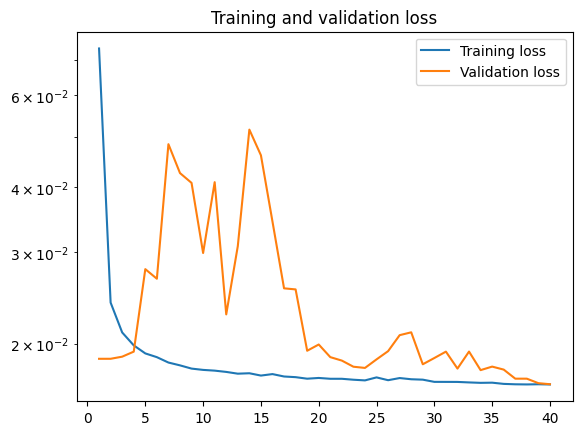

In [ ]:
# Importing necessary libraries
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy import stats
from sklearn.model_selection import train_test_split
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import model_from_json
import segmentation_models as sm
from segmentation_models import Unet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape, BatchNormalization
from ncps.wirings import AutoNCP
from ncps.tf import CfC,LTC


# Mount Google Drive
drive.mount('/content/drive')

# Function to scale input data
def scaled_in(matrix_spec):
    "Global scaling applied to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46) / 50
    return matrix_spec

# Function to scale output data
def scaled_ou(matrix_spec):
    "Global scaling applied to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec - 6) / 82
    return matrix_spec

# Function for training the model
def training_2(path_save_spectrogram, weights_path, epochs, batch_size):
    # Load noisy voice & clean voice spectrograms
    X_in = np.load(os.path.join(path_save_spectrogram, 'noisy_voice_amp_db.npy'))
    X_ou = np.load(os.path.join(path_save_spectrogram, 'voice_amp_db.npy'))

    # Model of noise to predict
    X_ou = X_in - X_ou

    # Check distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))

    # Scale input and output data
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    # Check shape of spectrograms
    print(X_in.shape)
    print(X_ou.shape)
    # Check new distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))

    # Reshape for training
    X_in = X_in[:,:,:]
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    X_ou = X_ou[:,:,:]
    X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

    # Split data into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)


    import segmentation_models as sm
    from segmentation_models import Unet
    from keras.layers import Input, Conv2D
    from keras.models import Model

    # define number of channels
    N = x_train.shape[-1]

    base_model = Unet(backbone_name='resnet101', encoder_weights='imagenet')

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model = Model(inp, out, name=base_model.name)
    BACKBONE = 'resnet101'
    preprocess_input = sm.get_preprocessing(BACKBONE)

    # preprocess input
    x_train = preprocess_input(x_train)
    x_val = preprocess_input(x_val)

    # define model
    model.compile(
    'Adam',
    loss = tf.keras.losses.MeanSquaredError(),
     metrics = ['mae']
    )

    # fitting model
    # Modify the checkpoint callback to save the model in the native Keras format
    checkpoint = ModelCheckpoint(weights_path+'/model_ResNet.keras', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

    #checkpoint = ModelCheckpoint(weights_path+'/model_ResNet.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint]
       )
    model_json = model.to_json()
    with open(os.path.join(weights_path, 'model_ResNet.json'), 'w') as json_file:
        json_file.write(model_json)

    # Plot training and validation loss (log scale)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.yscale('log')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# Call the training function
training_2('/content/drive/MyDrive/npy/', '/content/drive/MyDrive/npy/weights', epochs=40, batch_size=10)
